In [1]:
# Trick to import local code:
import sys
sys.path = ['/home/mp/michelj/src/sensorsio/src'] + sys.path

In [24]:
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
from sensorsio import pleiades, sentinel2, utils

In [3]:
# Path to products
phr_xs = '/work/scratch/michelj/cesbio/shr/aude/31TDH/2019/02/22/PHR1A_20190222_3863707101_31TDH/PHR1A_MS_20190222_3863707101_31TDH_TOC.tif'
s2 = '/datalake/S2-L2A-THEIA/31TDH/2019/02/22/SENTINEL2A_20190222-104908-287_L2A_T31TDH_C_V2-0/'

First, create the Sentinel2 dataset:

In [4]:
s2_ds = sentinel2.Sentinel2(s2)

Then, create the Pléiades dataset:

In [5]:
phr_ds = pleiades.Pleiades(phr_xs)

Lets Find the common bounding box between the Pléiades and the Sentinel2 image, and align the result on a 10m grid (origin will be a multiple of 10m). For this 

In [7]:
box, crs = utils.bb_common([s2_ds.bounds, phr_ds.bounds],[s2_ds.crs, phr_ds.crs],snap=10)
box, crs

(BoundingBox(left=432340.0, bottom=4742060.0, right=453160.0, top=4799800.0),
 CRS.from_epsg(32631))

Now we can read Pléiades buffer on this bounding box, and downsample it at 10 meters:

In [15]:
phr_arr, _, _, _ = phr_ds.read_as_numpy(pleiades.Pleiades.GROUP_XS,
                                        resolution=10,
                                        crs=crs,
                                        bounds=box,
                                        algorithm=rio.enums.Resampling.cubic)

Likewise, we can read Sentinel2 buffer on this bounding box:

In [16]:
s2_arr, _, _, _, _ = s2_ds.read_as_numpy(sentinel2.Sentinel2.GROUP_10M,
                                         resolution=10,
                                         crs=crs,
                                         bounds=box)

We can check that both buffer have compatible shape, and can therefore be used together for computations:

In [26]:
phr_arr.shape, s2_arr.shape

((4, 5774, 2082), (4, 5774, 2082))

The convenient ```utils.rgb_render``` allows to prepare images for rendering with **matplotlib**:

In [22]:
s2_rgb, dmin, dmax = utils.rgb_render(s2_arr, bands=[2,1,0], 
                                      dmin=np.array([0., 0., 0.]), 
                                      dmax=np.array([0.2,0.2,0.2]))
phr_rgb, dmin, max = utils.rgb_render(phr_arr, bands=[2,1,0], 
                                      dmin=dmin, 
                                      dmax=dmax)

We can now display both image side by side and check that they represent the same area:

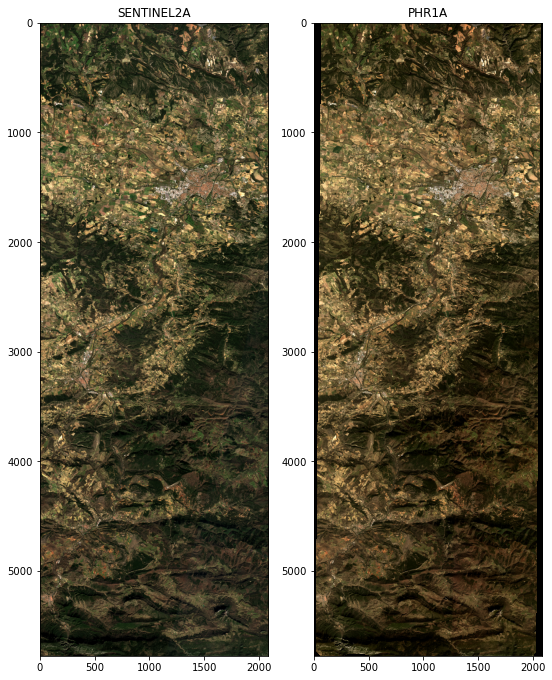

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(int(25*phr_rgb.shape[1]/phr_rgb.shape[0]), 25))
axes[0].imshow(s2_rgb)
axes[0].set_title(str(s2_ds.satellite.value))
axes[1].imshow(phr_rgb)
axes[1].set_title(str(phr_ds.satellite.value))
fig.show()